                                 **Macroeconomic Impact on Stock Market**

**Importing Libraries & Setting up**

In [27]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader.data import DataReader
from datetime import datetime
import statsmodels.api as sm

**Downloading Data**

In [28]:
#Defining time range
start = datetime(2010, 1, 1)
end = datetime(2024, 12, 31)

#Load datasets
# S&P 500 monthly close
sp500 = yf.download('^GSPC', start=start, end=end, interval='1mo')['Close']
sp500.name = 'SP500_Close'
sp500.index = sp500.index.to_period('M').to_timestamp()

# Unemployment rate (monthly from FRED)
unemployment = DataReader('UNRATE', 'fred', start, end)
unemployment = unemployment.rename(columns={'UNRATE': 'Unemployment_Rate'})
unemployment.index = unemployment.index.to_period('M').to_timestamp()

# GDP (quarterly % change, converted to monthly)
gdp = DataReader('GDP', 'fred', start, end)
gdp_growth = gdp.pct_change().dropna() * 100
gdp_growth = gdp_growth.rename(columns={'GDP': 'GDP_Growth'})
gdp_growth.index = gdp_growth.index.to_period('Q').to_timestamp(how='start')
gdp_monthly = gdp_growth.resample('M').ffill()
gdp_monthly.index = gdp_monthly.index.to_period('M').to_timestamp()

[*********************100%***********************]  1 of 1 completed
<ipython-input-28-84f4bd80eac3>:21: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



**All Data into One DataFrame**

In [29]:
#Merging all datasets
# Merge all with outer join, then drop missing
df = pd.concat([sp500, unemployment['Unemployment_Rate'], gdp_monthly['GDP_Growth']], axis=1)
df.dropna(inplace=True)
df.reset_index(inplace=True)
df.rename(columns={'index': 'Date'}, inplace=True)

# Final structure
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               175 non-null    datetime64[ns]
 1   ^GSPC              175 non-null    float64       
 2   Unemployment_Rate  175 non-null    float64       
 3   GDP_Growth         175 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 5.6 KB
None
        Date        ^GSPC  Unemployment_Rate  GDP_Growth
0 2010-04-01  1186.689941                9.9    1.460133
1 2010-05-01  1089.410034                9.6    1.460133
2 2010-06-01  1030.709961                9.4    1.460133
3 2010-07-01  1101.599976                9.4    1.077516
4 2010-08-01  1049.329956                9.5    1.077516


**Visualization before Cleaning**

**-Before jumping into data cleaning, we visualized the raw data to get an honest, upfront sense of how the S&P 500 behaves alongside unemployment and GDP growth. Doing this early helped us spot obvious trends and unusual patterns without losing context. It made the data feel more real — showing that when unemployment spikes, the market often dips, and how GDP growth usually supports stock performance. This step gave us intuition before analysis and helped guide what to clean and focus on later.**

**Line Plot: S&P 500 vs Unemployment Rate**

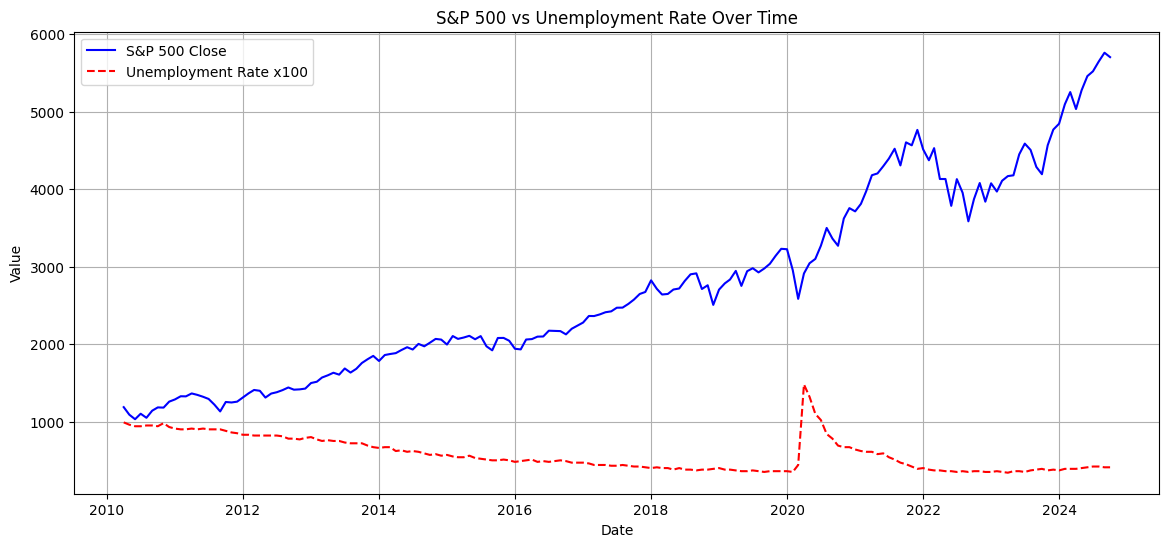

In [30]:
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['^GSPC'], label='S&P 500 Close', color='blue')
plt.plot(df['Date'], df['Unemployment_Rate'] * 100, label='Unemployment Rate x100', color='red', linestyle='--')
plt.title('S&P 500 vs Unemployment Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


**Line Plot: S&P 500 vs GDP Growth**

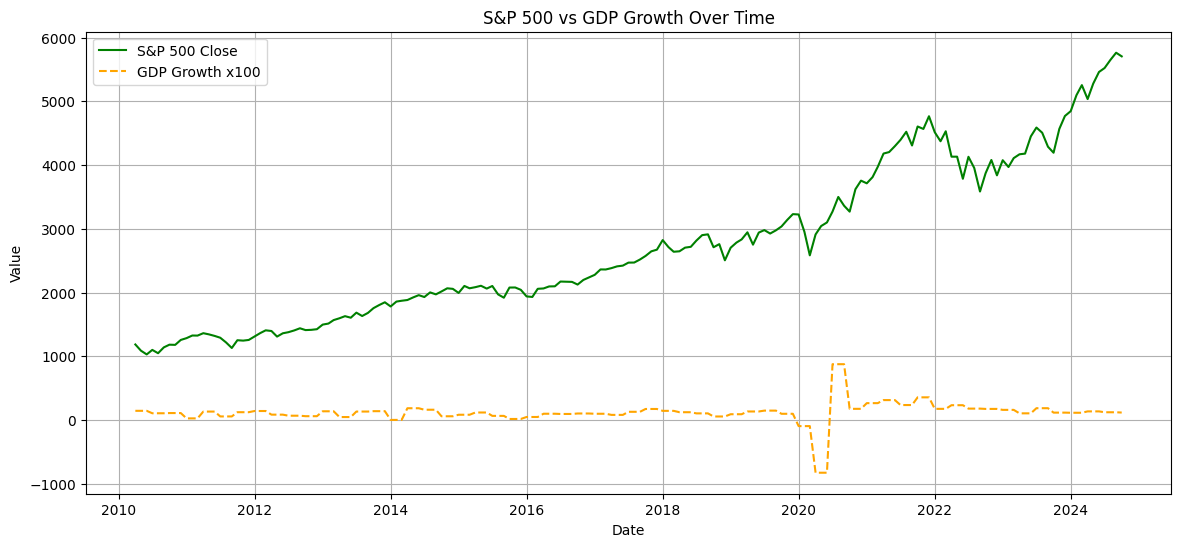

In [31]:
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['^GSPC'], label='S&P 500 Close', color='green')
plt.plot(df['Date'], df['GDP_Growth'] * 100, label='GDP Growth x100', color='orange', linestyle='--')
plt.title('S&P 500 vs GDP Growth Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

**Correlation Heatmap**

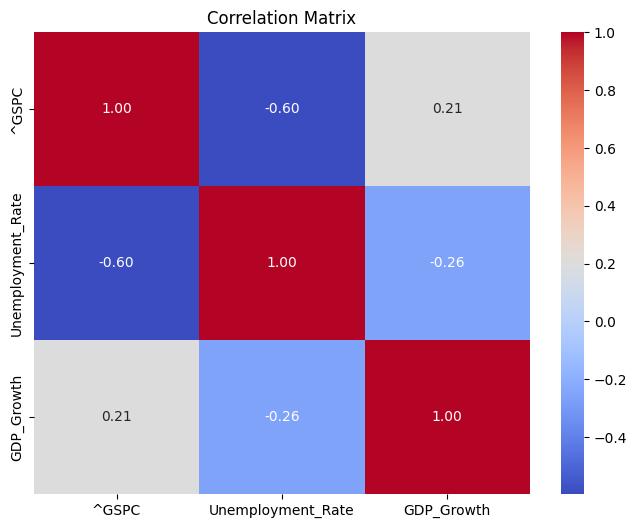

In [32]:
plt.figure(figsize=(8,6))
sns.heatmap(df.drop(columns=['Date']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

**Subplot View (All Together)**

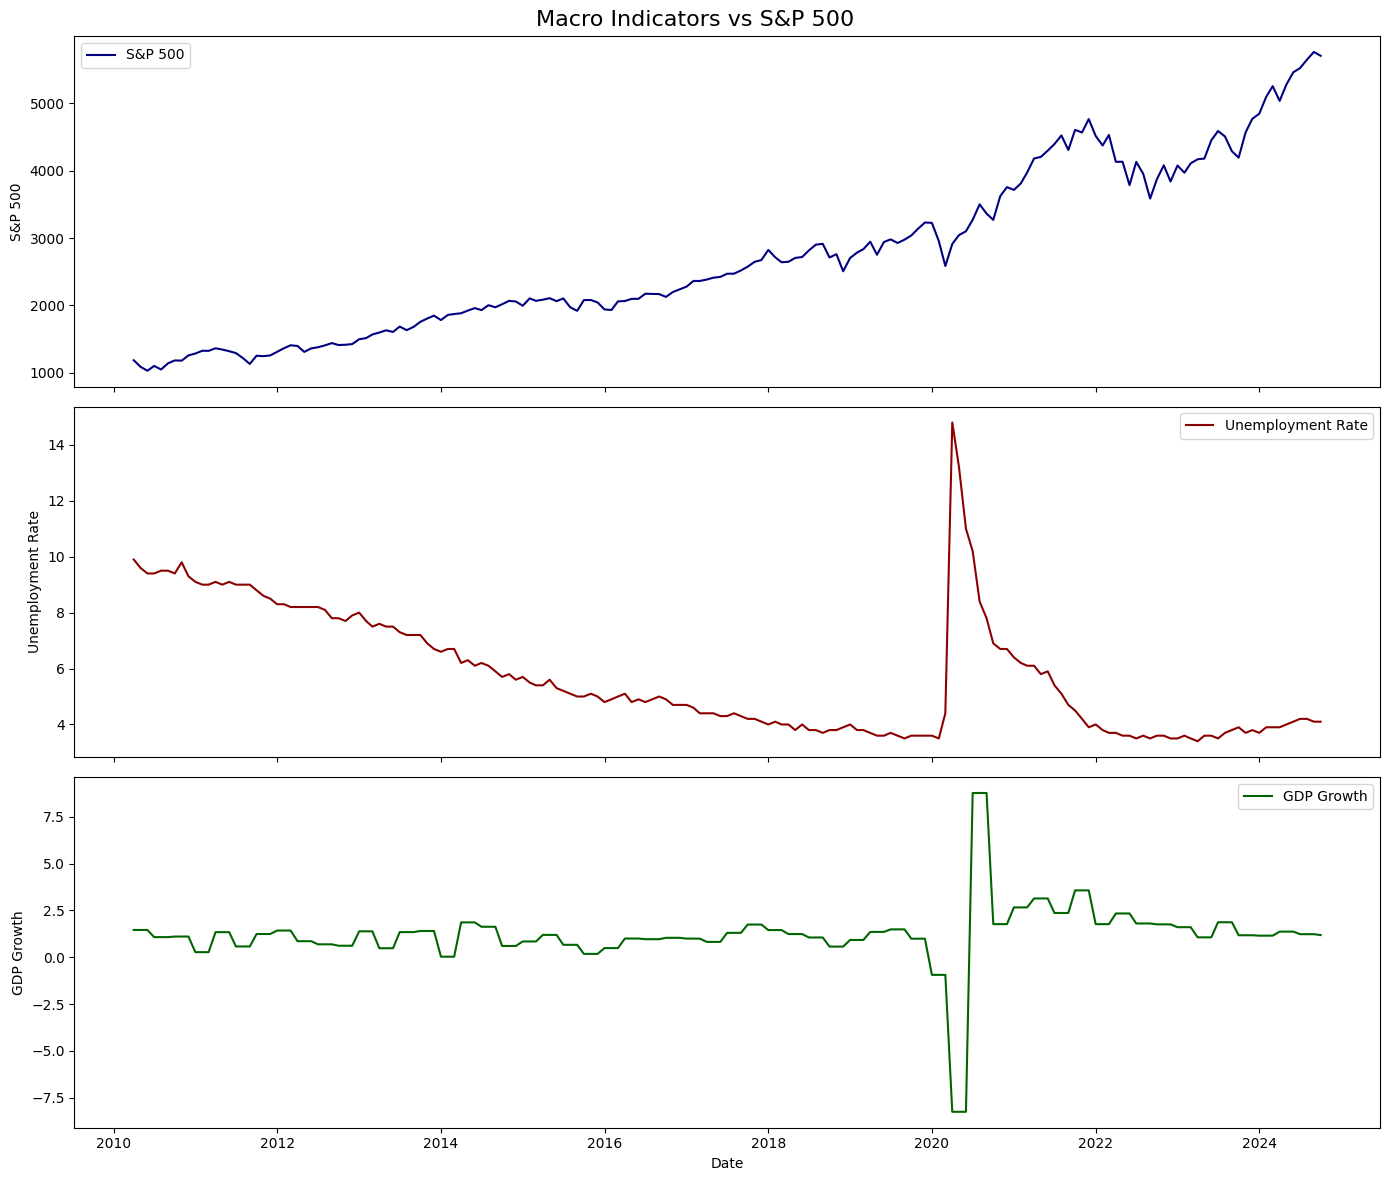

In [33]:
fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

axs[0].plot(df['Date'], df['^GSPC'], label='S&P 500', color='navy')
axs[0].set_ylabel('S&P 500')
axs[0].legend()

axs[1].plot(df['Date'], df['Unemployment_Rate'], label='Unemployment Rate', color='darkred')
axs[1].set_ylabel('Unemployment Rate')
axs[1].legend()

axs[2].plot(df['Date'], df['GDP_Growth'], label='GDP Growth', color='darkgreen')
axs[2].set_ylabel('GDP Growth')
axs[2].legend()

plt.suptitle('Macro Indicators vs S&P 500', fontsize=16)
plt.xlabel('Date')
plt.tight_layout()
plt.show()

**Model implementation - Vector AutoRegression (VAR)** model to understand how unemployment and GDP growth together influence the S&P 500 over time. The model looks at how each variable affects the others across previous months, capturing patterns and relationships. While the forecast gives a rough idea of market trends, the high RMSE shows there's room to improve by adding more features or fine-tuning the model.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



Selected lag order by AIC: 7


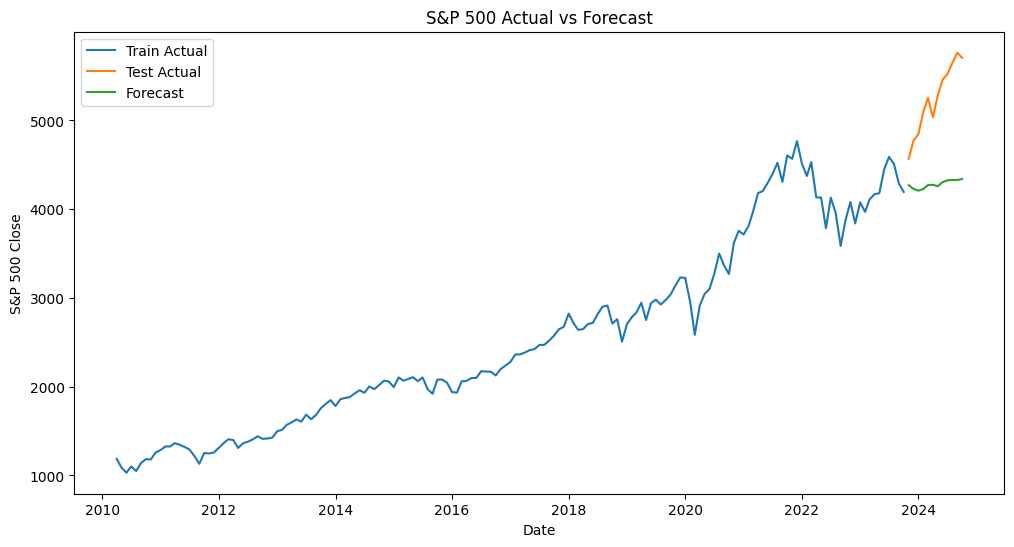

RMSE for S&P 500 forecast: 1022.99


In [34]:
import pandas as pd
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Prepare the data
df.set_index('Date', inplace=True)

# Select the relevant columns for the VAR model
data = df[['^GSPC', 'Unemployment_Rate', 'GDP_Growth']]

#Split data into train and test sets (last 12 months for testing)
train = data[:-12]
test = data[-12:]

# Step 4: Fit VAR model on training data
model = VAR(train)
# Select optimal lag order based on criteria (AIC here)
lag_order = model.select_order(maxlags=12)
print("Selected lag order by AIC:", lag_order.aic)

# Fit model with selected lag
var_model = model.fit(lag_order.aic)

#Forecast next 12 months
forecast_input = train.values[-lag_order.aic:]
forecast = var_model.forecast(y=forecast_input, steps=12)

# Convert forecast to DataFrame
forecast_df = pd.DataFrame(forecast, index=test.index, columns=data.columns)

# Plotting actual vs forecast for S&P 500
plt.figure(figsize=(12,6))
plt.plot(train.index, train['^GSPC'], label='Train Actual')
plt.plot(test.index, test['^GSPC'], label='Test Actual')
plt.plot(forecast_df.index, forecast_df['^GSPC'], label='Forecast')
plt.title('S&P 500 Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close')
plt.legend()
plt.show()

# Calculate forecast accuracy (RMSE)
rmse = np.sqrt(mean_squared_error(test['^GSPC'], forecast_df['^GSPC']))
print(f"RMSE for S&P 500 forecast: {rmse:.2f}")


**We used two forecasting models — VAR and ARIMA — to predict how the S&P 500 moves in response to economic conditions. ARIMA (AutoRegressive Integrated Moving Average) looks at patterns in the past values of the S&P 500 itself to forecast future prices. It doesn’t rely on external factors like unemployment or GDP — just the stock index’s own trend, momentum, and noise.**

**When we compared the models, ARIMA performed better with a lower RMSE than VAR, meaning it was more accurate in predicting S&P 500 movements in this case. This suggests that the market’s own past behavior was a stronger predictor than macroeconomic indicators. However, VAR still helped us understand the relationships between the economy and the stock market, offering more insight — even if it wasn’t the best for raw prediction.**

ARIMA Forecast for S&P 500: 2025-01-01    5926.757506
2025-02-01    5955.140248
2025-03-01    5982.190827
2025-04-01    6009.135424
2025-05-01    6036.071590
2025-06-01    6063.007085
2025-07-01    6089.942527
2025-08-01    6116.877965
2025-09-01    6143.813402
2025-10-01    6170.748839
2025-11-01    6197.684276
2025-12-01    6224.619714
Freq: MS, Name: predicted_mean, dtype: float64
RMSE for ARIMA model: 669.0061308894352


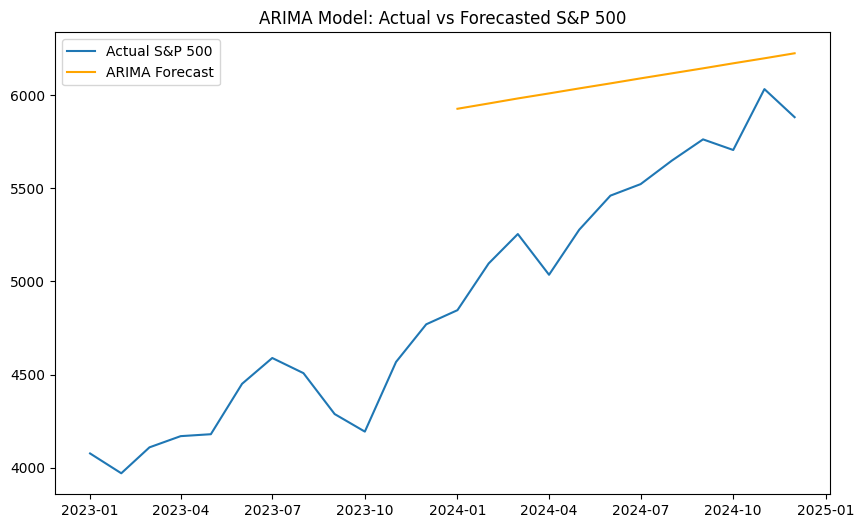

In [35]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

#Checking if the S&P 500 data is stationary
sp500_diff = sp500.diff().dropna()

#Fitting ARIMA model
model_arima = ARIMA(sp500_diff, order=(1, 0, 1))
arima_fit = model_arima.fit()

#Forecast using ARIMA model
forecast_arima = arima_fit.forecast(steps=12)

# Inverse the differencing
forecast_arima_cumsum = forecast_arima.cumsum() + sp500['^GSPC'].iloc[-1]

# Calculate RMSE for ARIMA
rmse_arima = np.sqrt(mean_squared_error(sp500['^GSPC'][-12:], forecast_arima_cumsum))

# Display results
print(f"ARIMA Forecast for S&P 500: {forecast_arima_cumsum}")
print(f"RMSE for ARIMA model: {rmse_arima}")

# Visualize ARIMA forecast vs actual values
plt.figure(figsize=(10, 6))
plt.plot(sp500.index[-24:], sp500['^GSPC'][-24:], label='Actual S&P 500')
plt.plot(sp500.index[-12:], forecast_arima_cumsum, label='ARIMA Forecast', color='orange')
plt.legend(loc='best')
plt.title('ARIMA Model: Actual vs Forecasted S&P 500')
plt.show()

**To understand how economic changes might impact the stock market, I used the same VAR model we trained earlier and ran "what-if" simulations. I created two scenarios — one with rising unemployment and falling GDP, and one with improving economic conditions. The model forecasted how the S&P 500 might respond. The results showed that bad economic news had a stronger negative impact on the market, helping visualize future risk in a simple, clear way.**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



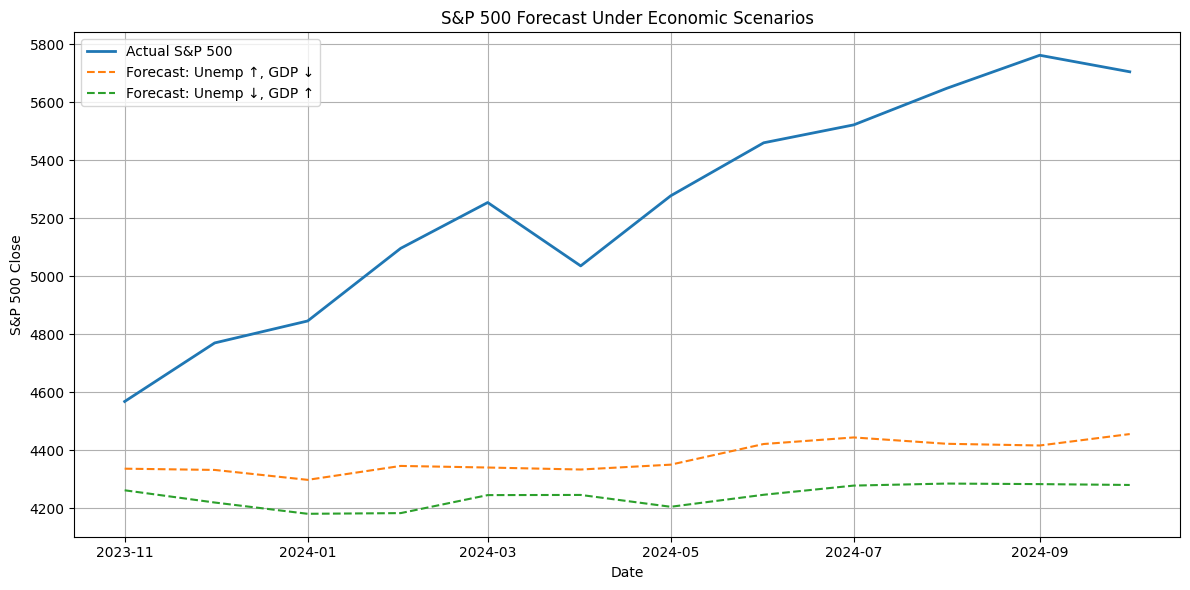

In [36]:
# WHAT-IF SCENARIO ANALYSIS
data = df[['^GSPC', 'Unemployment_Rate', 'GDP_Growth']]
train = data[:-12]
test = data[-12:]

# Fit VAR model
model = VAR(train)
lag_order = model.select_order(maxlags=12).aic
var_model = model.fit(lag_order)

# Simulate different economic scenarios
last_input = train.values[-lag_order:]

# Scenario 1: Unemployment ↑2%, GDP ↓1%
scenario1 = last_input.copy()
scenario1[-1, 1] += 2.0
scenario1[-1, 2] -= 1.0

# Scenario 2: Unemployment ↓1%, GDP ↑1%
scenario2 = last_input.copy()
scenario2[-1, 1] -= 1.0
scenario2[-1, 2] += 1.0

# Forecast under both scenarios
forecast1 = var_model.forecast(y=scenario1, steps=12)
forecast2 = var_model.forecast(y=scenario2, steps=12)

forecast1_df = pd.DataFrame(forecast1, index=test.index, columns=data.columns)
forecast2_df = pd.DataFrame(forecast2, index=test.index, columns=data.columns)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['^GSPC'], label='Actual S&P 500', linewidth=2)
plt.plot(forecast1_df.index, forecast1_df['^GSPC'], label='Forecast: Unemp ↑, GDP ↓', linestyle='--')
plt.plot(forecast2_df.index, forecast2_df['^GSPC'], label='Forecast: Unemp ↓, GDP ↑', linestyle='--')
plt.title("S&P 500 Forecast Under Economic Scenarios")
plt.xlabel("Date")
plt.ylabel("S&P 500 Close")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**visualisation**

**-The dashboard visualizes how key macroeconomic indicators—S&P 500 stock market index, unemployment rate, and GDP growth—change over time. Using an interactive checklist, we can select which indicators to display on a time series line chart. The code loads and prepares the data, then uses Dash to create a user-friendly web app where these trends are plotted dynamically, helping explore relationships between the economy and the stock market.**

In [37]:

!pip install dash jupyter-dash pandas plotly --quiet


df.rename(columns={
    '^GSPC': '^GSPC',
    'UNRATE': 'Unemployment_Rate',
    'GDP': 'GDP_Growth'
}, inplace=True)

# Convert Date column to datetime and set as index if needed
if 'Date' not in df.columns:
    df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

# Initialize app
app = JupyterDash(__name__)

app.layout = html.Div([
    html.H1("Macroeconomic Impact on Stock Market Dashboard"),

    html.Div([
        html.Label("Select Indicators:"),
        dcc.Checklist(
            id='indicator-checklist',
            options=[
                {'label': 'S&P 500 Close', 'value': '^GSPC'},
                {'label': 'Unemployment Rate', 'value': 'Unemployment_Rate'},
                {'label': 'GDP Growth', 'value': 'GDP_Growth'}
            ],
            value=['^GSPC'],
            inline=True
        ),
    ]),

    dcc.Graph(id='time-series-plot')
])

@app.callback(
    Output('time-series-plot', 'figure'),
    Input('indicator-checklist', 'value')
)
def update_graph(selected_indicators):
    fig = go.Figure()
    colors = {'^GSPC': 'blue', 'Unemployment_Rate': 'red', 'GDP_Growth': 'green'}

    for indicator in selected_indicators:
        if indicator in df.columns:
            fig.add_trace(go.Scatter(
                x=df['Date'],
                y=df[indicator],
                mode='lines',
                name=indicator,
                line=dict(color=colors.get(indicator, 'black'))
            ))

    fig.update_layout(
        title="Selected Indicators Over Time",
        xaxis_title="Date",
        yaxis_title="Value",
        hovermode="x unified",
        template="plotly_white"
    )
    return fig

# Run the app in Colab inline
app.run(mode='inline')

/usr/local/lib/python3.11/dist-packages/dash/dash.py:587: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



<IPython.core.display.Javascript object>